# Helper functions

In [20]:
def hash_sensor_order(order):
    hash = 0
    for i in range(4):
        hash += order[i] * 4 ** i
    return hash

In [21]:
hash_sensor_order([3,2,0,1])

75

# Objective

In the previous notebook, we diagnosed a potential issue with the initial CF yaw guess that the code performs when trying to find the pose of the BS in the CF reference frame. The original code implementation assumes the BS is above the CF pointing down at it, which is an assumption we're now breaking. In this notebook, we'll go through each of the functions which are involved in estimating the pose of the BS, and update them to allow for a CF flipped on its side, and base stations on both the floor and ceiling. These are:

1. `_find_initial_yaw_guess` estimates yaw based on sensor order mappings
2. `_convert_yaw_to_open_cv` converts the yaw to a CF pose in the BS reference frame (but a "camera" version of it)
3. `_estimate_pose_by_pnp(bs_vectors, rvec_guess, tvec_guess)` does something
4. `_opencv_to_cf(rw_ocv, tw_ocv)` does something else

## (1) Update `find_initial_yaw_guess`

The lighthouse deck which is mounted on the CF looks like this:

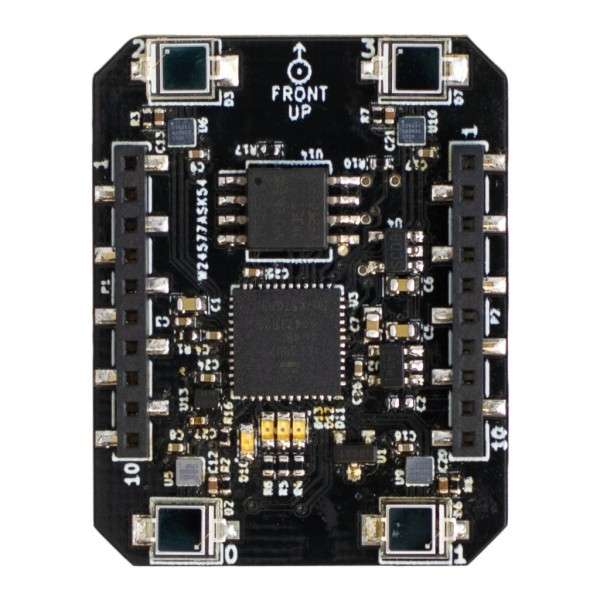

I'm assuming the numbers on the edges correspond to the sensor IDs during operation.

The pre-set yaw angle to sensor order mapping is as follows (this assumes the BS is above the CF pointing down at it)

In [62]:
import math

# Numbers passed to math.radians are angles
directions = {
    hash_sensor_order([2, 0, 1, 3]): math.radians(0),
    hash_sensor_order([2, 0, 3, 1]): math.radians(25),
    hash_sensor_order([2, 3, 0, 1]): math.radians(65),
    hash_sensor_order([3, 2, 0, 1]): math.radians(90),
    hash_sensor_order([3, 2, 1, 0]): math.radians(115),
    hash_sensor_order([3, 1, 2, 0]): math.radians(155),
    hash_sensor_order([1, 3, 2, 0]): math.radians(180),
    hash_sensor_order([1, 3, 0, 2]): math.radians(205),
    hash_sensor_order([1, 0, 3, 2]): math.radians(245),
    hash_sensor_order([0, 1, 3, 2]): math.radians(270),
    hash_sensor_order([0, 1, 2, 3]): math.radians(295),
    hash_sensor_order([0, 2, 1, 3]): math.radians(335),
}

If you imagine a CF with a lighthouse deck on top, with sensors numbered as in the picture above, the degree values in this map make sense for the different sensor orders (to intuit this better I labelled the corners of a piece of paper with the sensor numbers and rotated it around, imagining I was a base station doing horizontal scans).

In order to have both an up-sensor and down-sensor BS be in "view", the CF needs to be turned on its side:

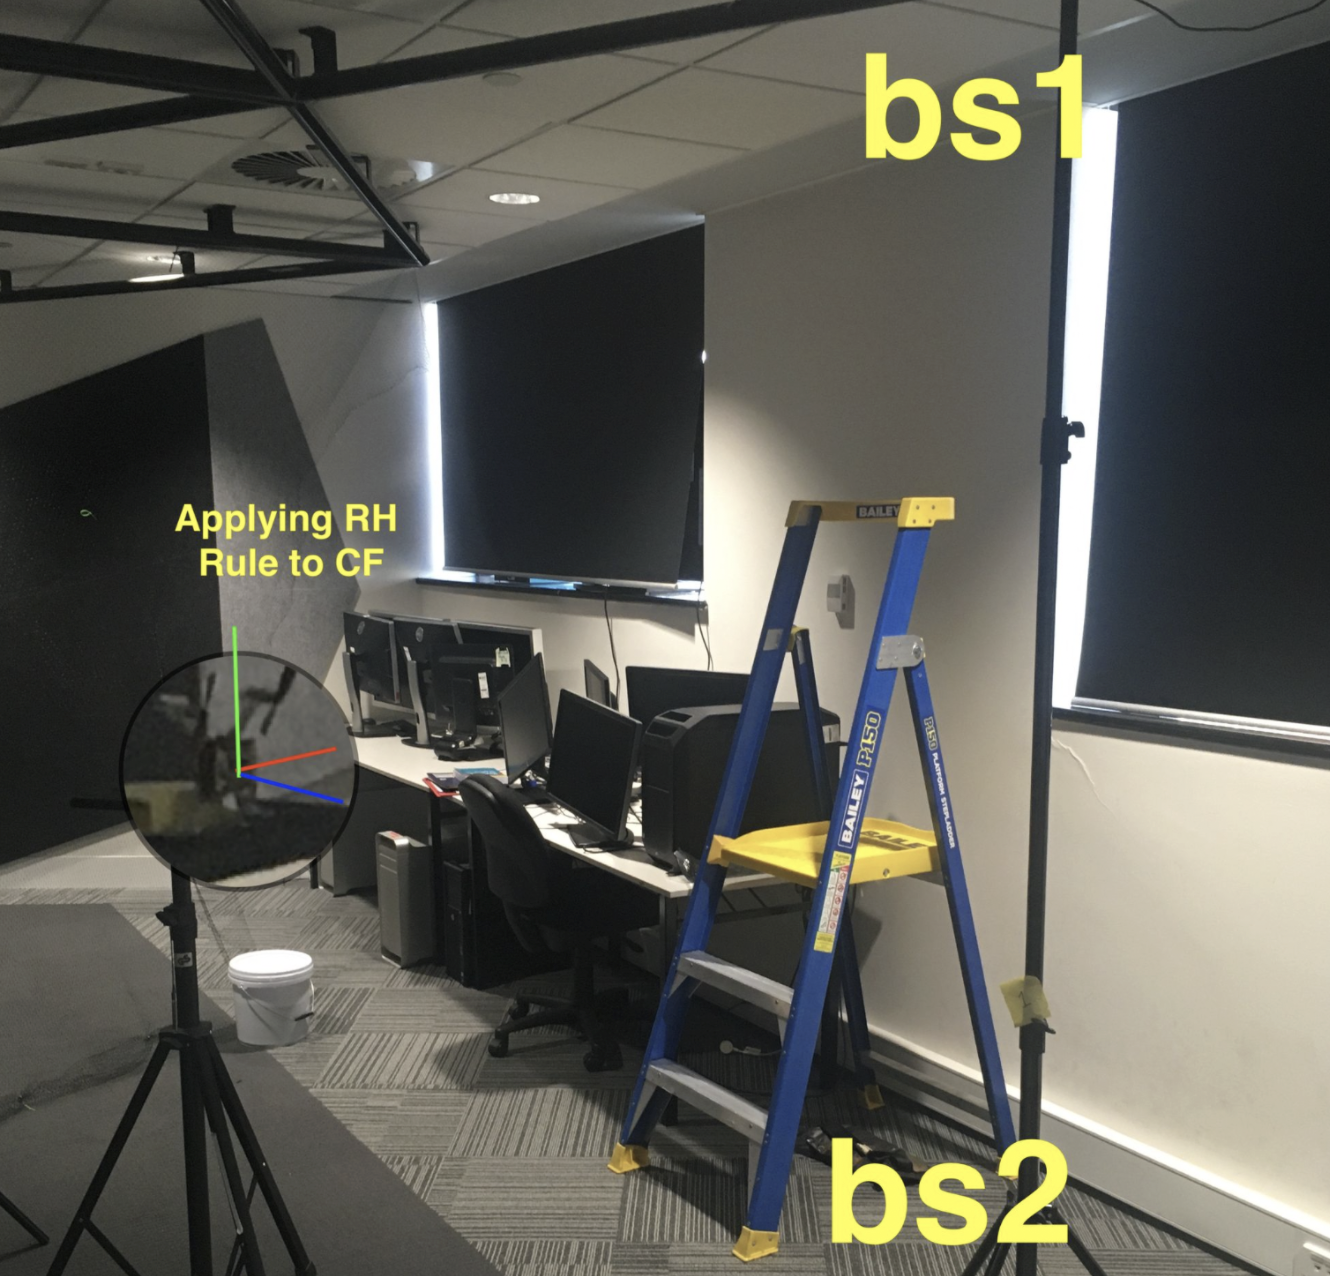

In this configuration, we want to apply a "flipped" set of initial yaw guesses for the base station on the ceiling, i.e. we can modify the code as follows:

In [27]:
flipped_directions = {
    hash_sensor_order([2, 0, 1, 3]): math.radians(0 + 180),
    hash_sensor_order([2, 0, 3, 1]): math.radians(25 + 180),
    hash_sensor_order([2, 3, 0, 1]): math.radians(65 + 180),
    hash_sensor_order([3, 2, 0, 1]): math.radians(90 + 180),
    hash_sensor_order([3, 2, 1, 0]): math.radians(115 + 180),
    hash_sensor_order([3, 1, 2, 0]): math.radians(155 + 180),
    hash_sensor_order([1, 3, 2, 0]): math.radians(180 + 180),
    hash_sensor_order([1, 3, 0, 2]): math.radians(205 - 180),
    hash_sensor_order([1, 0, 3, 2]): math.radians(245 - 180),
    hash_sensor_order([0, 1, 3, 2]): math.radians(270 - 180),
    hash_sensor_order([0, 1, 2, 3]): math.radians(295 - 180),
    hash_sensor_order([0, 2, 1, 3]): math.radians(335 - 180),
}


def bs_is_on_ceiling(bs_id):
    if bs_id == 0:
        return True
    if bs_id == 1:
        return True
    if bs_id == 2:
        return False


def find_initial_yaw_guess(bs_vectors, bs_id, sideways):
   
    sweeps_x = {
        0: bs_vectors[0].lh_v1_horiz_angle,
        1: bs_vectors[1].lh_v1_horiz_angle,
        2: bs_vectors[2].lh_v1_horiz_angle,
        3: bs_vectors[3].lh_v1_horiz_angle
    }

    ordered_map_x = {k: v for k, v in
                     sorted(sweeps_x.items(), key=lambda item: item[1])}
    sensor_order_x = list(ordered_map_x.keys())

    if sideways:
        if bs_is_on_ceiling(bs_id):
            # BS is on ceiling
            return flipped_directions[hash_sensor_order(sensor_order_x)]
        else:
            # BS is on floor
            return directions[hash_sensor_order(sensor_order_x)]
    else:
        # The base station is roughly in this direction, in CF (world) coordinates
        return directions[hash_sensor_order(sensor_order_x)]

This appears to work:

In [63]:
import pickle

upways_sensor_data_path = "sensor_data_1614655937013395.pickle"
sideways_sensor_data_path = "sensor_data_1614655377286432.pickle"

sideways_sensor_data = pickle.load(open(sideways_sensor_data_path, "rb"))
upways_sensor_data = pickle.load(open(upways_sensor_data_path, "rb"))

print("Upways:")

for id in sorted(upways_sensor_data.keys()):
    average_data = upways_sensor_data[id]
    sensor_data = average_data[1]
    print(f"Base station {id} yaw estimate: {math.degrees(find_initial_yaw_guess(sensor_data, id, sideways=False))} degrees")

print("Sideways (as in picture above - note a positive yaw rotation is down in the image):")
    
for id in sorted(sideways_sensor_data.keys()):
    average_data = sideways_sensor_data[id]
    sensor_data = average_data[1]
    print(f"Base station {id} yaw estimate: {math.degrees(find_initial_yaw_guess(sensor_data, id, sideways=True))} degrees")



Upways:
Base station 0 yaw estimate: 295.0 degrees
Base station 1 yaw estimate: 115.0 degrees
Sideways (as in picture above - note a positive yaw rotation is down in the image):
Base station 1 yaw estimate: 295.0 degrees
Base station 2 yaw estimate: 65.0 degrees


# (2) Update `_convert_yaw_to_open_cv` 

Next, we look at `_convert_yaw_to_open_cv`. This function takes the yaw guess (which is from the perspective of the CF), and uses it to make an initial guess of the pose of the CF in BS coordinates (camera coordinates this time). I expect there's some assumptions baked into this code about the relative positions of the CF and BS, which we'll need to adjust. Unfortunately, there's not much in the code to tell us what it's doing, so I'll first run through and understand it properly. 

## A run-through of the original version

Here's the original version:

In [31]:
# Calculate rotation matrix

import math
import numpy as np
import cv2 as cv

def convert_yaw_to_open_cv(yaw):
    
    # Base station height
    bs_h = 2.0
    # Distance to base station along the floor
    bs_fd = 3.0
    # Distance to base station
    bs_dist = math.sqrt(bs_h ** 2 + bs_fd ** 2)
    elevation = math.atan2(bs_h, bs_fd)

    # Initial position of the CF in camera coordinate system, open cv style
    tvec_start = np.array([0, 0, bs_dist])

    # Calculate rotation matrix
    d_c = math.cos(-yaw + math.pi)
    d_s = math.sin(-yaw + math.pi)
    R_rot_y = np.array([
        [d_c, 0.0, d_s],
        [0.0, 1.0, 0.0],
        [-d_s, 0.0, d_c],
    ])

    e_c = math.cos(elevation)
    e_s = math.sin(elevation)
    R_rot_x = np.array([
        [1.0, 0.0, 0.0],
        [0.0, e_c, -e_s],
        [0.0, e_s, e_c],
    ])

    R = np.dot(R_rot_x, R_rot_y)
    rvec_start, _ = cv.Rodrigues(R)

    return rvec_start, tvec_start

The "camera coordinate" system appears to be as follows, based on [this open cv documentation](https://docs.opencv.org/master/d9/d0c/group__calib3d.html) (ctrl-f "detailed description"):

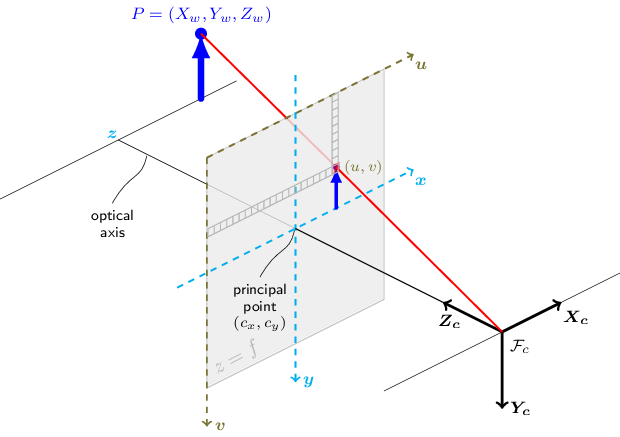

Note that the Y axis is now pointing down in the world reference system (so negative Z in the normal BS reference system), and the Z axis is pointing directly out the front of the "lens" (so positive X in the normal BS reference system)


Given this, taking the `convert_yaw_to_open_cv` step by step:

1. We estimate the distance `bs_dist` from the CF to the BS based on pre-canned values for base station height and distance along floor (2 and 3 respectively)
2. We guess that the position of the CF in the BS camera coordinate system (BSCC) is directly in front of it in the Z direction, i.e. the middle of the camera lens is pointing directly at it.
3. We now look at the rotation of the CF in the BSCC. We look at its probable rotation about the BSCC Y-axis, which is going to be based on our yaw guess. This is `R_rot_y`. We then look at its probable rotation about the BSCC X-axis, which is going to correlate to the elevation of the CF. We don't look at its rotation about the BSCC Z-axis, presumably because we're assuming the elevation angle is sufficiently shallow. 
4. To look at the CF's rotation about the BSCC X-axis, we first calculate the elevation angle of the BS with respect to the CF. To do this, we use the same pre-canned values as in (1) for height (H) and distance along floor (D), taking advantage of the assumption that the CF is directly straight ahead in the BSCC Z axis:

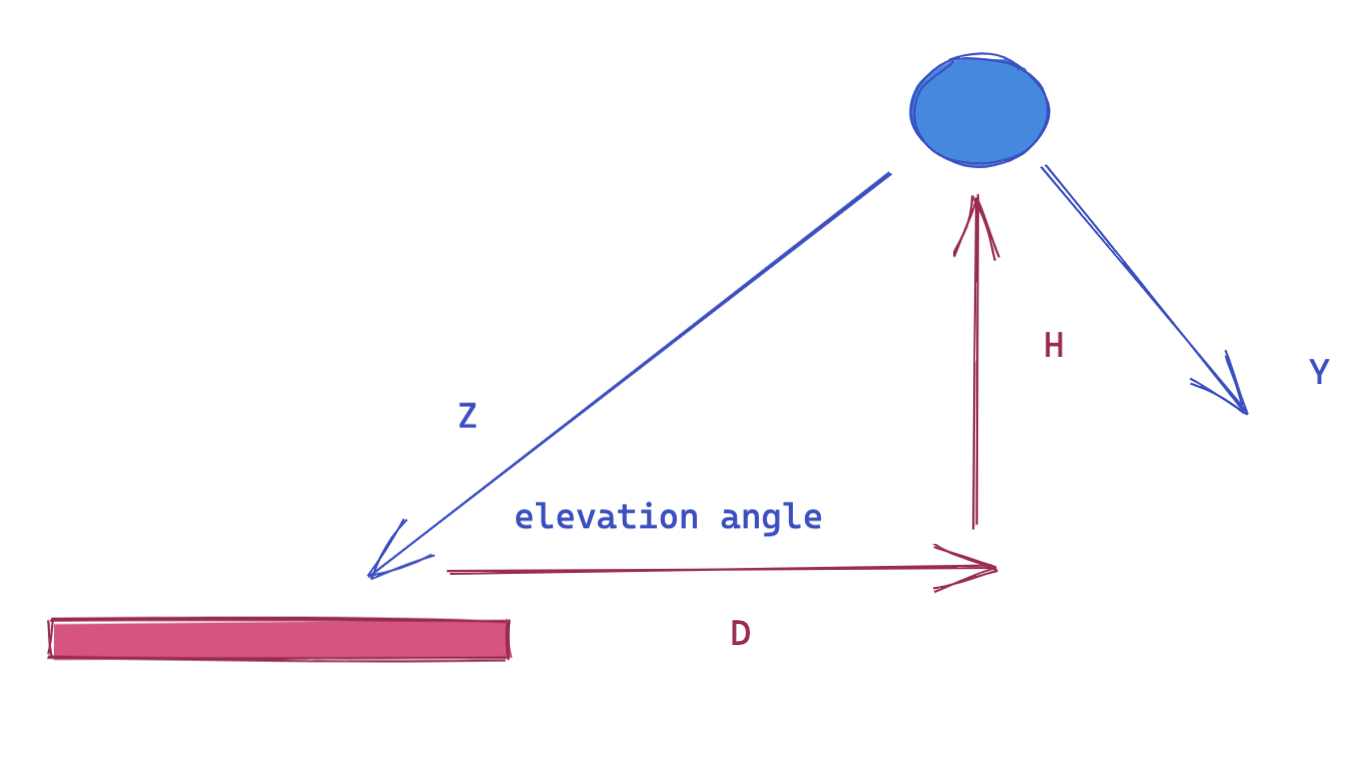

(the pink deck is the CF and the blue orb is the BS). This gives us the rotation of the CF about the BSCC X-axis:

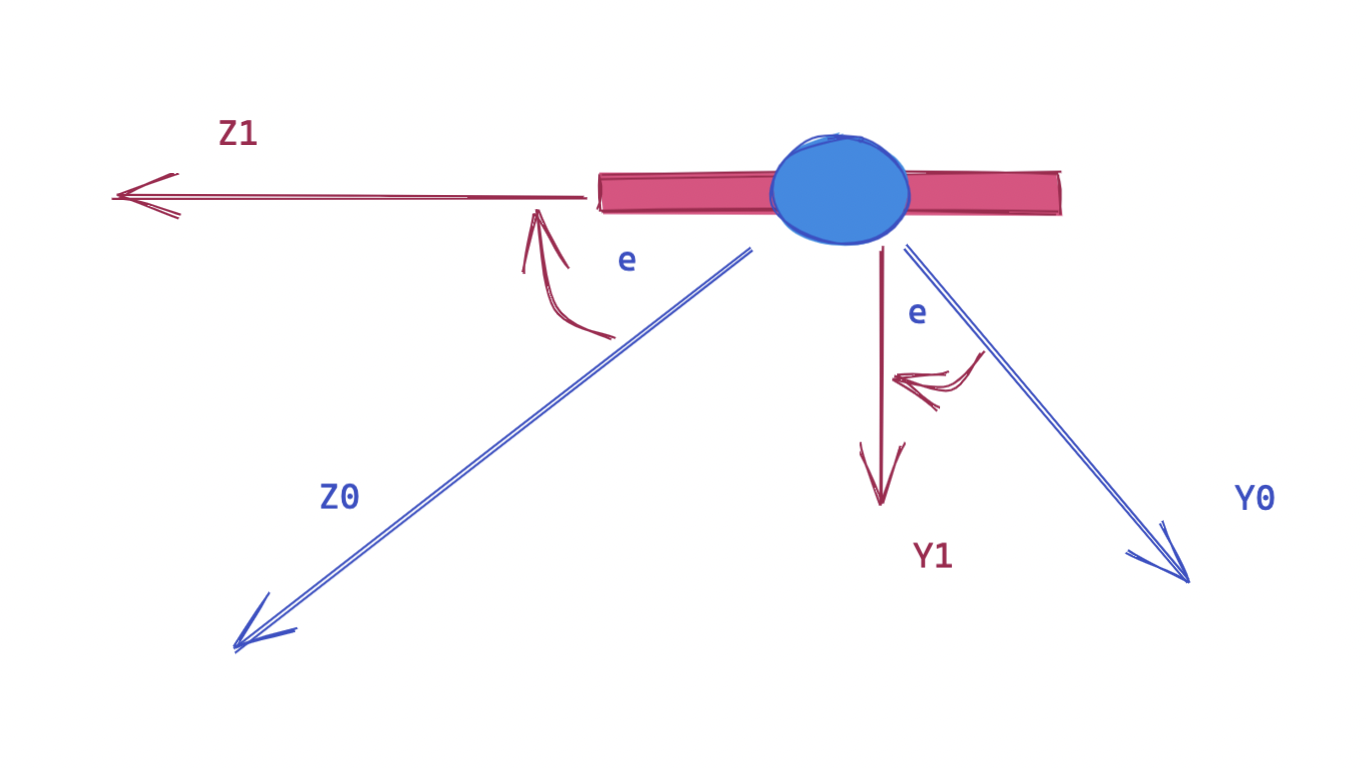

Double-checking that the values we get from the ensuing rotation matrix are the same as the ones in the code above:

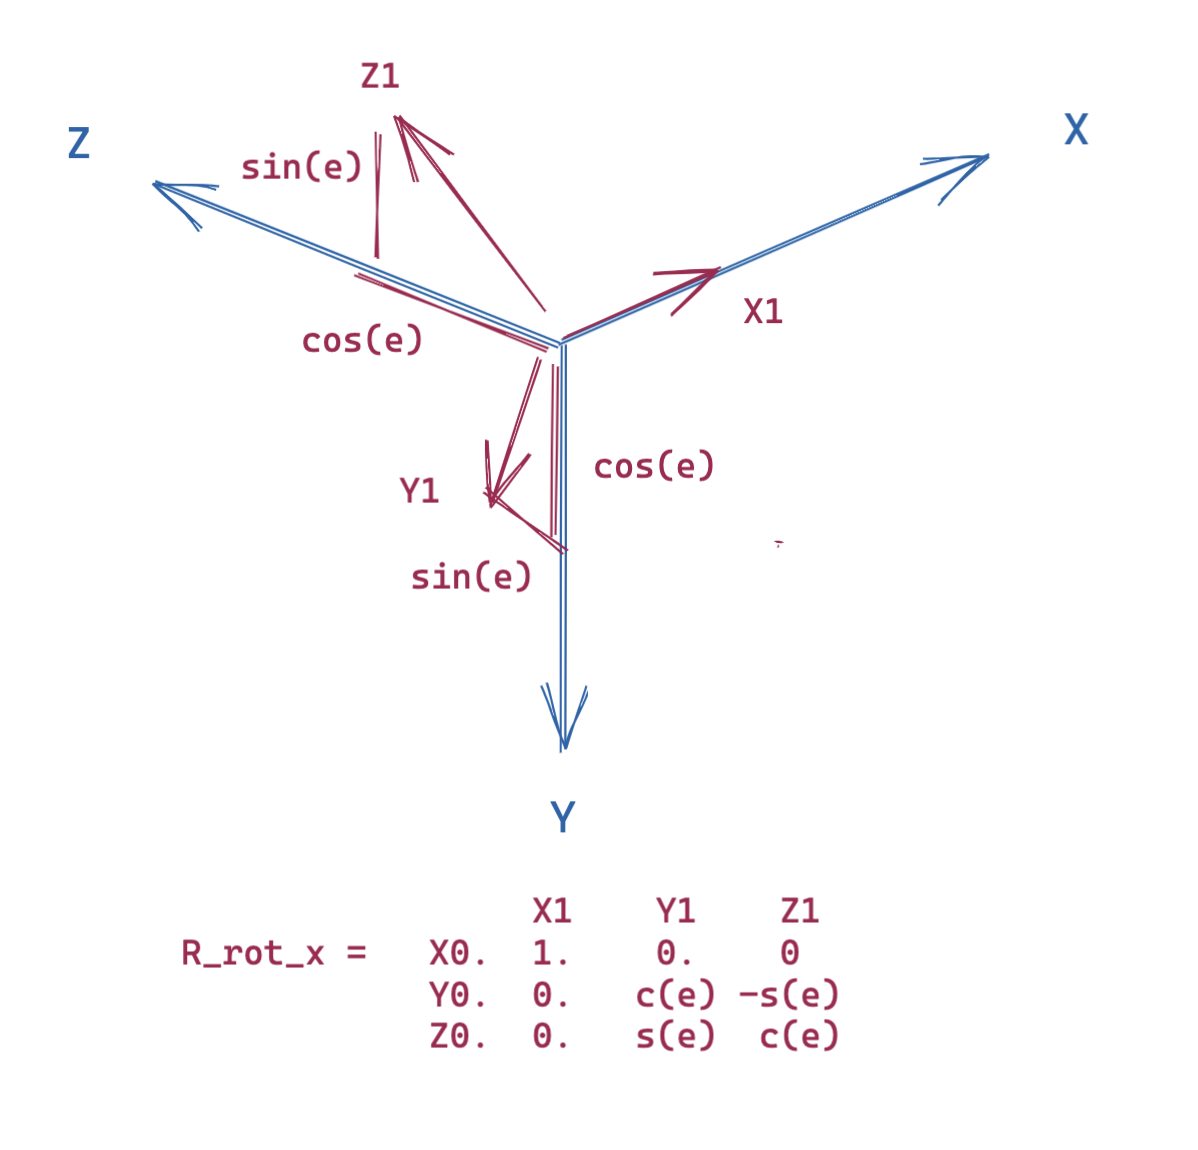

They are. You can work this out yourself by calculating each element of the matrix as the projection of the row onto the column, i.e. the top left element is the projection of X1 onto X2. There's a good explanation of this process here: https://www.youtube.com/watch?v=lVjFhNv2N8o

5. To look at the CF's rotation about the BSCC Y-axis, we do a similar thing, but with the yaw angle that we guessed earlier. The assumption here is that the yaw is occurring in the BSCC X-Z plane. Note also in the code that we mirror the yaw angle so that we're looking at things from the perspective of the BS rather than the perspective of the CF:

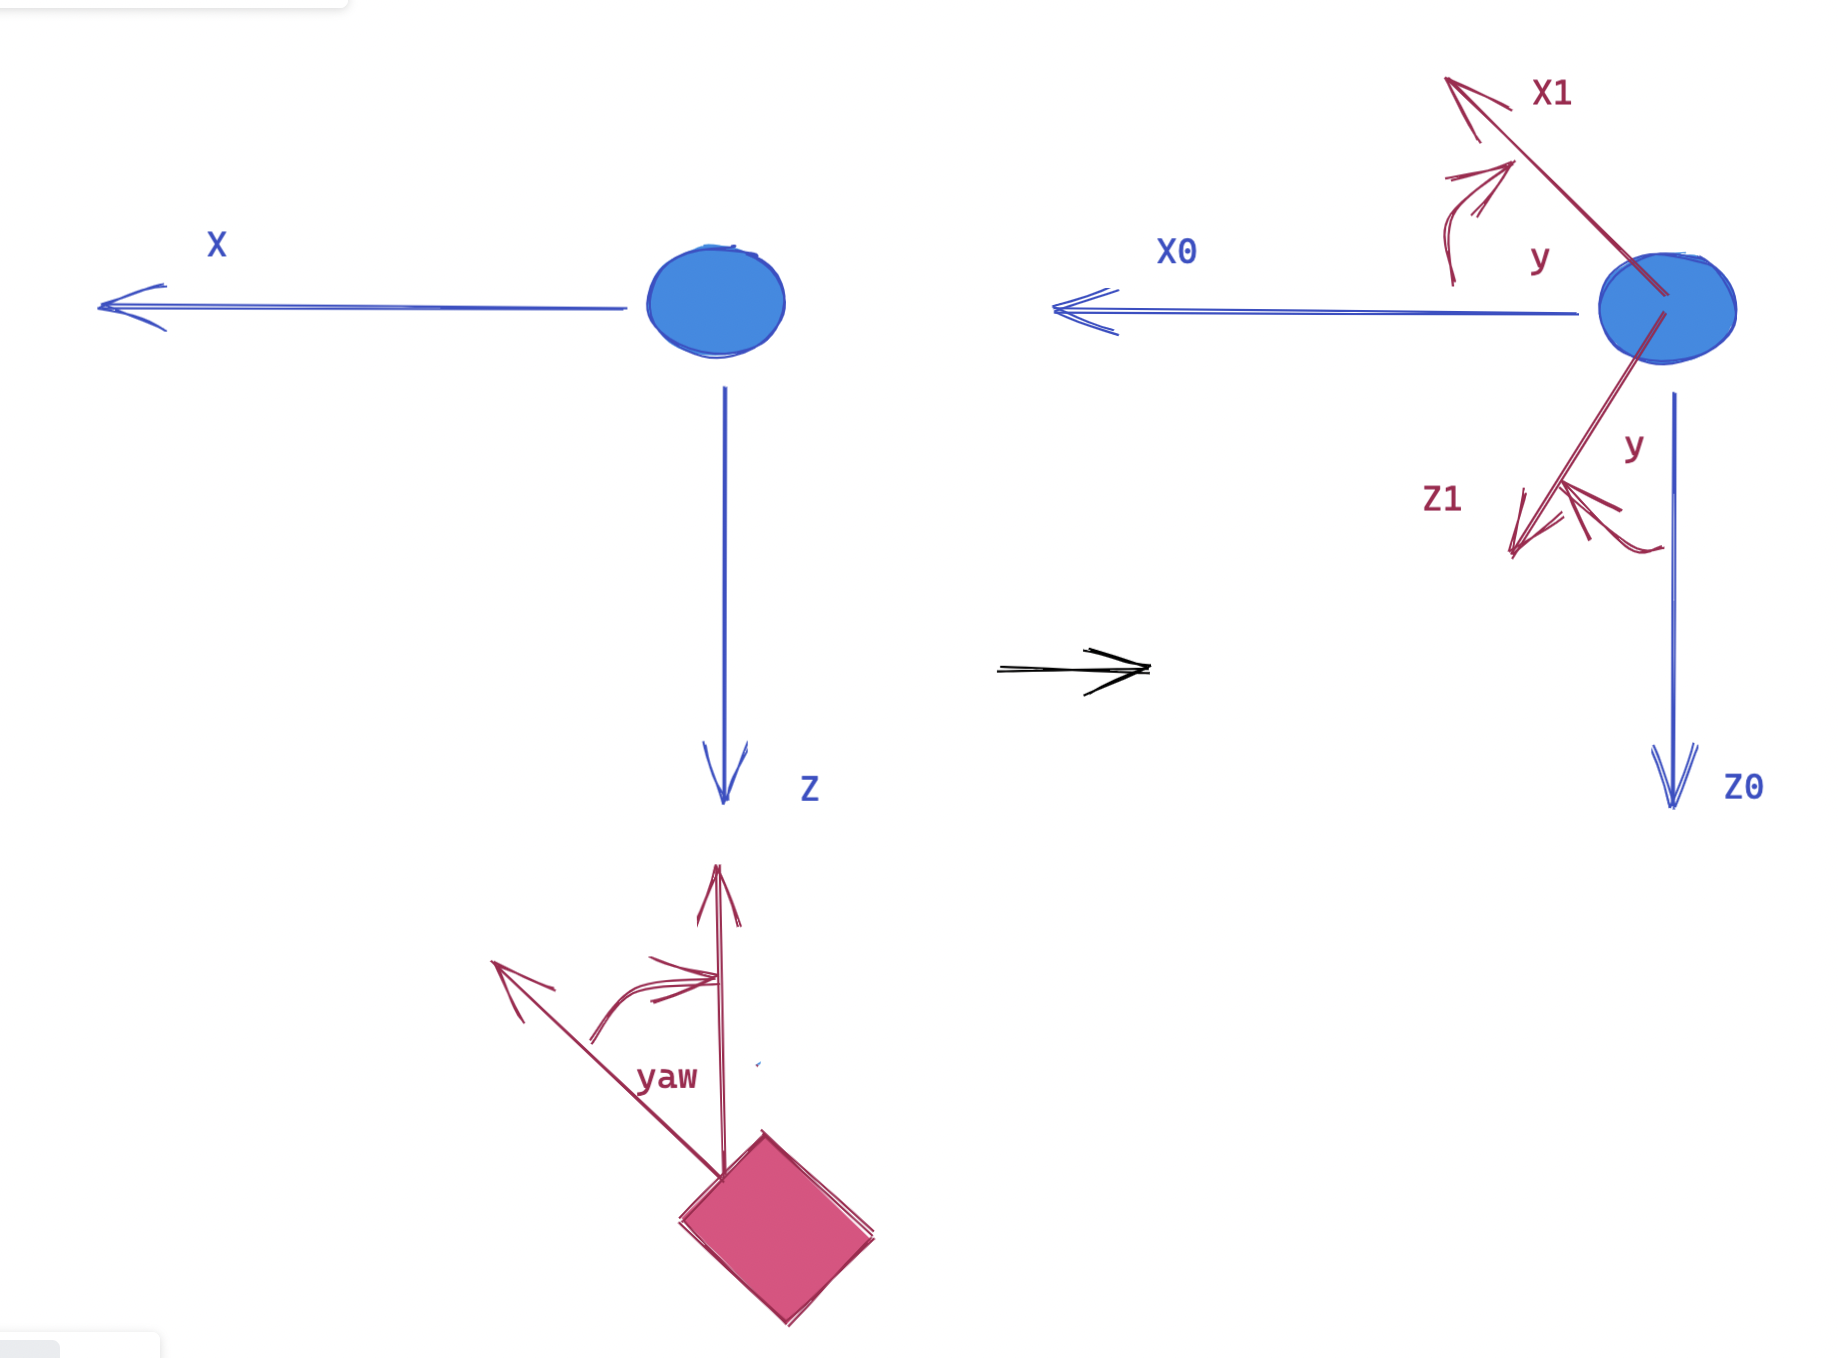

And then the rotation matrix:

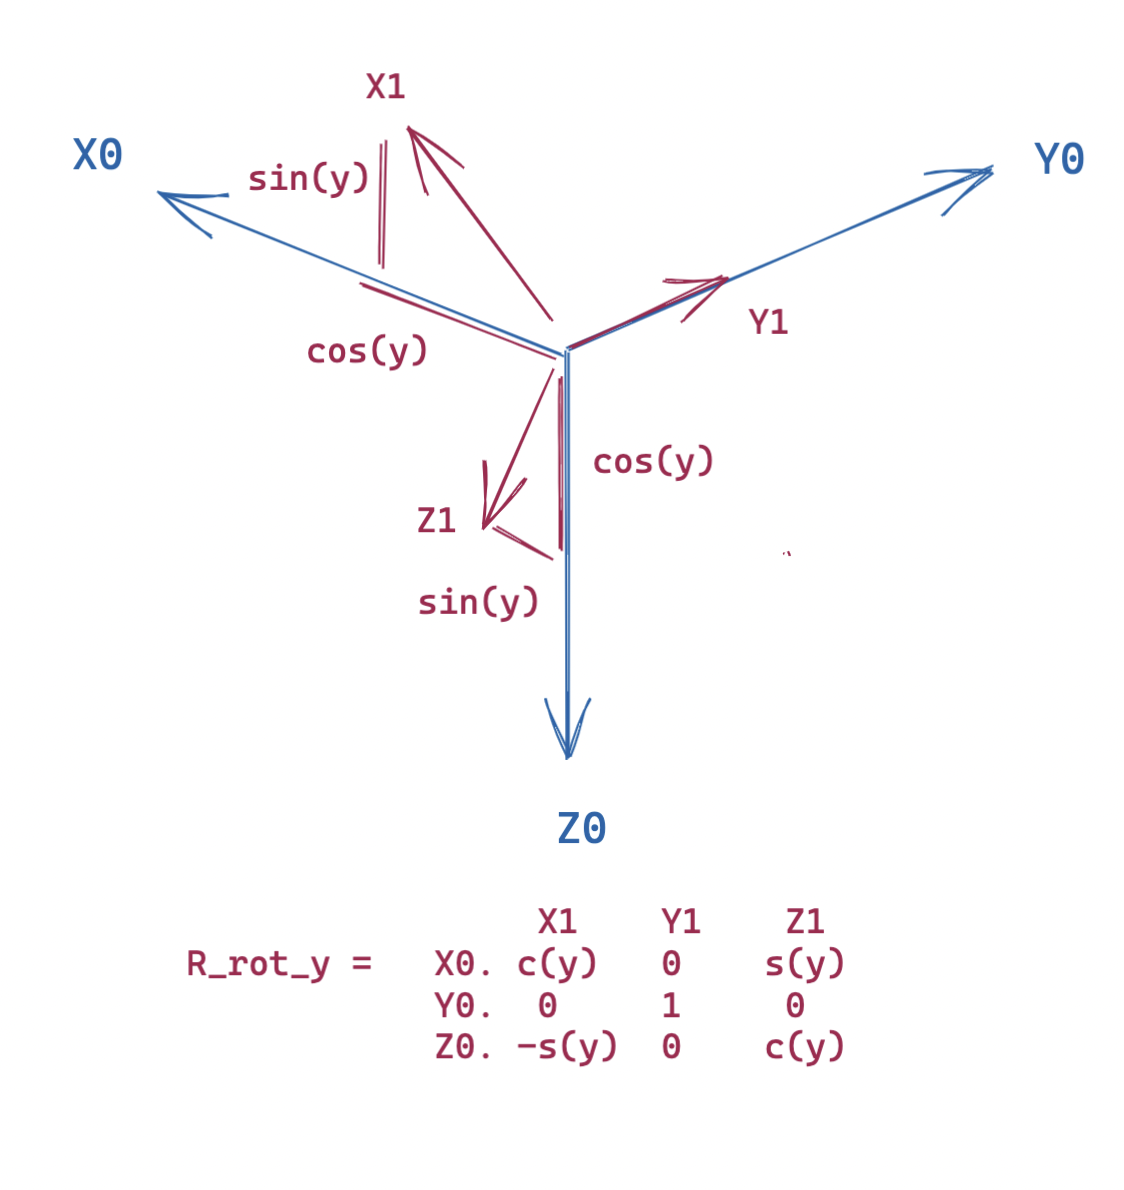

We can see this is the same as in the code. 

6. We then take the dot product of the `R_rot_x` and `R_rot_y` (`np.dot(R_rot_x, R_rot_y)`). The result of this is the rotation matrix you'd get if you first performed the `R_rot_y` rotation, then the `R_rot_x` rotation.
7. Lastly, we convert the rotation matrix that comes out of (6) into a rotation vector using `cv.Rodrigues(R)`


## Updates to the code for a sideways world

It looks like we'll have to update the code based on the following changed conditions:

1. Our elevation angle now occurs in a different CF plane
2. We're assuming that the CF is aligned with the BSCC X-Y plane (and therefore the yaw is occurring in that plane), rather than the BSCC X-Z plane